# GLM

By Charles Xu @ DJA Lab, Caltech

## Set up environment

In [3]:
# Import packages
# import sys; sys.path.insert(0, r'/Users/alveus/Documents/WorkingDirectory/Packages/Python')
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

# import ssm
# from ssm.util import find_permutation

In [4]:
# User inputs
data_path = r'/Users/alveus/Documents/WorkingDirectory/Data/DJA/Jineun/PythonData/EG1-4/priority_malemale' # Path to data on my Mac
data_name = r'DJA_JK_EG1-4-fasted-0629-regis from fed male_neural_behavior_py.mat'
# data_name = r'EG1-4-fed-0730-corrected_1026_neural_behavior_py.mat'
data_fullfile = data_path + '/' + data_name
frame_rate = 10 # Frame rate of the data (in Hz)
time_window = 5 # Time window for regressors (in seconds)
time_step = 5 # Time step for the regressors (in frames)
n_folds = 5 # Number of folds for cross-validation
good_beta_threshold = 0.5 # Threshold for good betas as a proportion of the maximum beta

### Load data

In [5]:
# Load data
mat = sio.loadmat(data_fullfile)
input_raw = mat['behaviorFullMaFPS']
output_raw = np.array(mat['neural_ref'])
# output_raw = np.array(mat['neural_data_fed_0703'])
labels_raw = mat['behaviorNames']
labels = []
for i in range(len(labels_raw)):
    labels.append(labels_raw[i][0][0])

## Processing data

### Process variables

In [6]:
# Define function to smooth data
def smooth(data, window_size):
    '''
    data: 1D array of raw trace
    window_size: int of window size for smoothing
    '''
    smoothed = np.convolve(data, np.ones(window_size+1, dtype=int) / window_size, 'valid')
    r = np.arange(1, window_size, 2)
    start = np.cumsum(data[:window_size])[::2]/r
    stop = (np.cumsum(data[:-window_size:-1])[::2]/r)[::-1]
    return np.concatenate((start, smoothed, stop))

In [7]:
# Process variables
# input_raw = np.delete(input_raw, 2, axis=0) # Leave out variables

output_smoothed = np.zeros_like(output_raw)
smooth_window = int(frame_rate * 2) # Window size for smoothing (2 seconds)
for i in range(output_raw.shape[0]):
    output_smoothed[i] = smooth(output_raw[i], smooth_window)

# del labels[2] # Leave out variable labels
input_labeled = {label: input_raw[i] for i, label in enumerate(labels)} # Create dictionary of input variables with labels

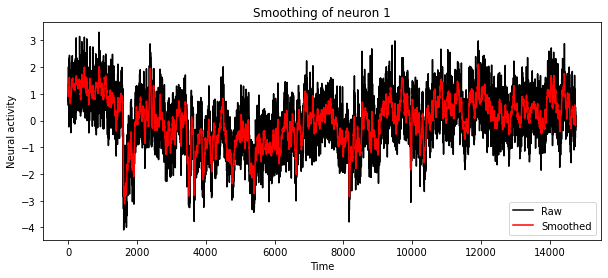

In [8]:
# Plot smoothing
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(output_raw[0, :], color='k', label='Raw')
ax.plot(output_smoothed[0, :], color='r', label='Smoothed')
ax.set_xlabel('Time')
ax.set_ylabel('Neural activity')
ax.set_title(f'Smoothing of neuron 1')
ax.legend()

### Make design matrix

In [7]:
# Define function to make the design matrix
def make_design_matrix(input_raw, time_window, frame_rate, time_step):
    """
    data: input data
    time_window: time window for design matrix (plus or minus)
    frame_rate: frame rate of data
    """
    num_rows = input_raw.shape[0]
    num_shifts = int(time_window * frame_rate // time_step)
    design_matrix = np.zeros((num_rows*(2*num_shifts+1), input_raw.shape[1]))

    for i in range(num_rows):
        for j in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
            if j == 0:
                design_matrix[i*(num_shifts*2+1)+j//time_step+num_shifts, :] = input_raw[i,:]
            elif j < 0:
                design_matrix[i*(num_shifts*2+1)+j//time_step+num_shifts, :j] = input_raw[i,-j:]
            else:
                design_matrix[i*(num_shifts*2+1)+j//time_step+num_shifts, j:] = input_raw[i,:-j]
    return design_matrix.T

In [8]:
# Make the design matrix
x = make_design_matrix(input_raw, time_window, frame_rate, time_step)
y = output_smoothed.T
xd = x.shape[1]
yd = y.shape[1]
tt = x.shape[0]
print(f'Features of x: {xd}')
print(f'Features of y: {yd}')
print(f'Total time points: {tt}')

Features of x: 273
Features of y: 73
Total time points: 14759


### Normalize data by z-score

In [9]:
# z-score the data
# x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
# y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

## Fit GLMs

In [10]:
# Set up k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0) # Initialize KFold object, with deterministic output

### Fit using simple linear regression

In [11]:
# Fit linear regression model
linreg = linear_model.LinearRegression()

betas_lin = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_lin = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    linreg.fit(x_train, y_train) # Fit ridge regression model
    betas_lin[:,:,i] = linreg.coef_ # Store betas

    y_pred = linreg.predict(x_test) # Predict y
    r2_lin[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_lin = np.mean(betas_lin, axis=2) # Average betas across folds
r2_lin = np.mean(r2_lin, axis=1) # Average R2 across folds


### Fit using ridge regression which penalizes $\beta$ by $L_2$ regularization

#### Determine the best complexity parameter, $\alpha$, using grid search CV

In [12]:
# Set up grid search CV
alpha_test_range = 10**np.linspace(-10,9,50) # Get search values for alpha on log scale

fit_intercept = False # If y is mean-centered, set to False
alpha_per_target = True # Allow every neuron to be regularized individualy for better model performance

# Perform grid search CV using RidgeCV
ridge_grid_search = linear_model.RidgeCV(alphas=alpha_test_range, fit_intercept=fit_intercept, scoring='r2', store_cv_values=True, alpha_per_target=alpha_per_target)
ridge_grid_search.fit(x,y)
alphas = ridge_grid_search.alpha_

Text(0, 0.5, 'Count')

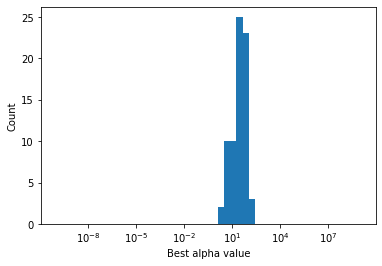

In [13]:
# Distribution of best alphas
fig,ax = plt.subplots()
ax.hist(alphas, bins=alpha_test_range)
ax.set_xscale('log')
ax.set_xlabel('Best alpha value')
ax.set_ylabel('Count')

#### Fit ridge regression

In [14]:
# Fit ridge regression model
ridgereg = linear_model.Ridge(alpha=alphas, fit_intercept=fit_intercept) # Initialize Ridge object

betas_ridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_ridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    ridgereg.fit(x_train, y_train) # Fit ridge regression model
    betas_ridge[:,:,i] = ridgereg.coef_ # Store betas

    y_pred = ridgereg.predict(x_test) # Predict y
    r2_ridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_ridge = np.mean(betas_ridge, axis=2) # Average betas across folds
r2_ridge = np.mean(r2_ridge, axis=1) # Average R2 across folds

#### Fit ridge regression with non-negativity constraint

Note that the non-negative ridge only allows for the lbfgs solver, which is an optimisation algorithm and does not reach a closed-form solution

In [15]:
# Fit ridge regression with non-negative constraints with lbfgs solver
nnridgereg = linear_model.Ridge(alpha=alphas, fit_intercept=fit_intercept, solver='lbfgs', positive=True) # Initialize Ridge object

betas_nnridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_nnridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    nnridgereg.fit(x_train, y_train) # Fit ElasticNet regression model
    betas_nnridge[:,:,i] = nnridgereg.coef_ # Store betas

    y_pred = nnridgereg.predict(x_test) # Predict y
    r2_nnridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_nnridge = np.mean(betas_nnridge, axis=2) # Average betas across folds
r2_nnridge = np.mean(r2_nnridge, axis=1) # Average R2 across folds

### Fit using LASSO regression which penalizes $\beta$ by $L_1$ regularization

## Assess model performance

### Cross-validated R-squared score

In [16]:
# Define function to plot R-squared values
def plot_r2(r2, yd, color='r'):
    idx = np.argsort(r2)[::-1]

    fig, ax = plt.subplots()
    ax.plot(r2[idx], color = color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, yd])
    ax.set_ylim([0,max(r2)])
    ax.set_xlabel('Neuron number')
    ax.set_ylabel('cross-validated R\u00b2')

    # Print best R-squared and best fit neuron
    best_r2 = max(r2)
    best_fit_neuronidx = np.argmax(r2)
    
    print(f'Best R\u00b2: {best_r2}')
    print(f'Best fit neuron: {best_fit_neuronidx+1}')
    return ax, best_fit_neuronidx

Best R²: 0.6939895750259707
Best fit neuron: 60
Best R²: 0.6386307123086269
Best fit neuron: 60
Best R²: 0.4878968570724439
Best fit neuron: 60


Text(0.5, 1.0, 'Non-negative ridge regression')

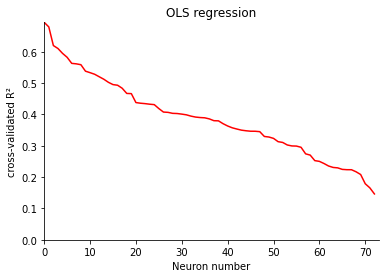

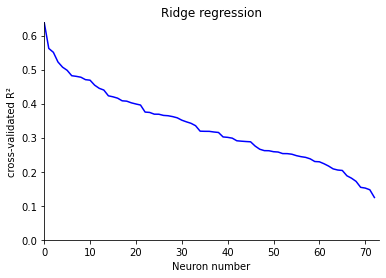

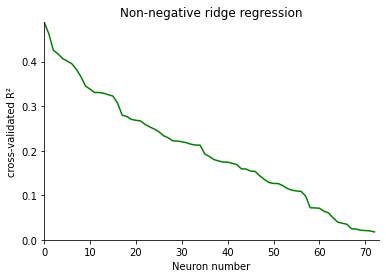

In [17]:
# Plot R-squared for each neuron using OLS
ax, best_fit_neuronidx_lin = plot_r2(r2_lin, yd)
ax.set_title('OLS regression')

# Plot R-squared for each neuron using ridge regression
ax, best_fit_neuronidx_ridge = plot_r2(r2_ridge, yd, color='b')
ax.set_title('Ridge regression')

# Plot R-squared for each neuron using non-negative ridge regression
ax, best_fit_neuronidx_nnridge = plot_r2(r2_nnridge, yd, color='g')
ax.set_title('Non-negative ridge regression')

### Plot beta weights for each regressors

In [18]:
# Reshape betas to be 3D (neuron x behavior x regressor)
betas_lin_reshaped = betas_lin.reshape((yd, input_raw.shape[0], x.shape[1]//input_raw.shape[0]))
betas_ridge_reshaped = betas_ridge.reshape((yd, input_raw.shape[0], x.shape[1]//input_raw.shape[0]))
betas_nnridge_reshaped = betas_nnridge.reshape((yd, input_raw.shape[0], x.shape[1]//input_raw.shape[0]))

In [51]:
# Define function to plot beta weights for each input variable
def plot_inputvar_betas(betas_reshaped, neuron_id, labels, time_step, color='b'):
    '''
    betas_reshaped: 3D array of betas (neuron x behavior x regressor)
    labels: list of input variable labels
    '''
    neuron_idx = neuron_id - 1
    num_labels = len(labels)

    fig, axs = plt.subplots(nrows=np.ceil(num_labels/2).astype(int), ncols=2, figsize=(10, 4*num_labels//2), constrained_layout=True)

    for i in range(num_labels):
        row = i // 2
        col = i % 2
        axs[row, col].plot(np.arange(-(betas_reshaped.shape[2] // 2), betas_reshaped.shape[2] // 2 + 1) * time_step, betas_reshaped[neuron_idx, i, :].T, color=color)
        axs[row, col].hlines(0, -(betas_reshaped.shape[2] // 2) * time_step, (betas_reshaped.shape[2] // 2) * time_step, color='k', linestyle='--')
        axs[row, col].set_xticks(np.arange(-(betas_reshaped.shape[2] // 2), betas_reshaped.shape[2] // 2 + 1, time_step) * time_step)
        axs[row, col].set_xticklabels(np.arange(-(betas_reshaped.shape[2] // 2), betas_reshaped.shape[2] // 2 + 1, time_step) * time_step // frame_rate)
        axs[row, col].set_ylim([np.amin(betas_reshaped[neuron_idx, :, :]), np.amax(betas_reshaped[neuron_idx, :, :])])
        axs[row, col].set_title(labels[i])
        axs[row, col].set_xlabel('Time (s)')
        axs[row, col].set_ylabel('Beta weight')

        if i == num_labels - 1 and num_labels % 2 == 1:
            axs[row, col+1].axis('off')

    fig.suptitle(f'Beta weights for neuron {neuron_id}')
    return fig, axs

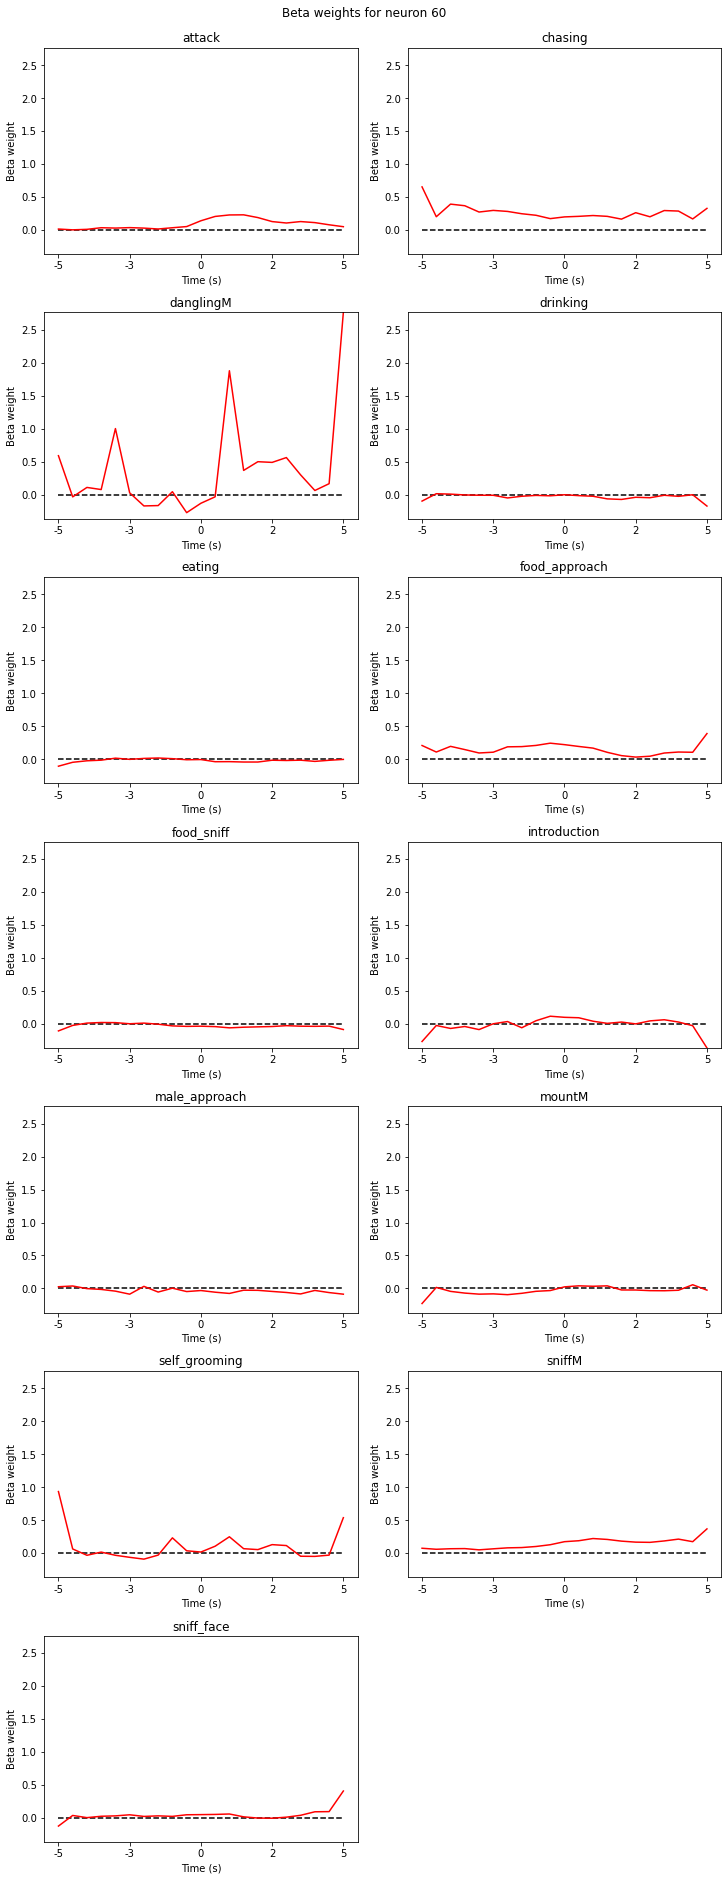

In [52]:
# Plot betas for each behavior using OLS (for best fit neuron using OLS)
fig, axs = plot_inputvar_betas(betas_lin_reshaped, best_fit_neuronidx_lin+1, labels, time_step, color='r')

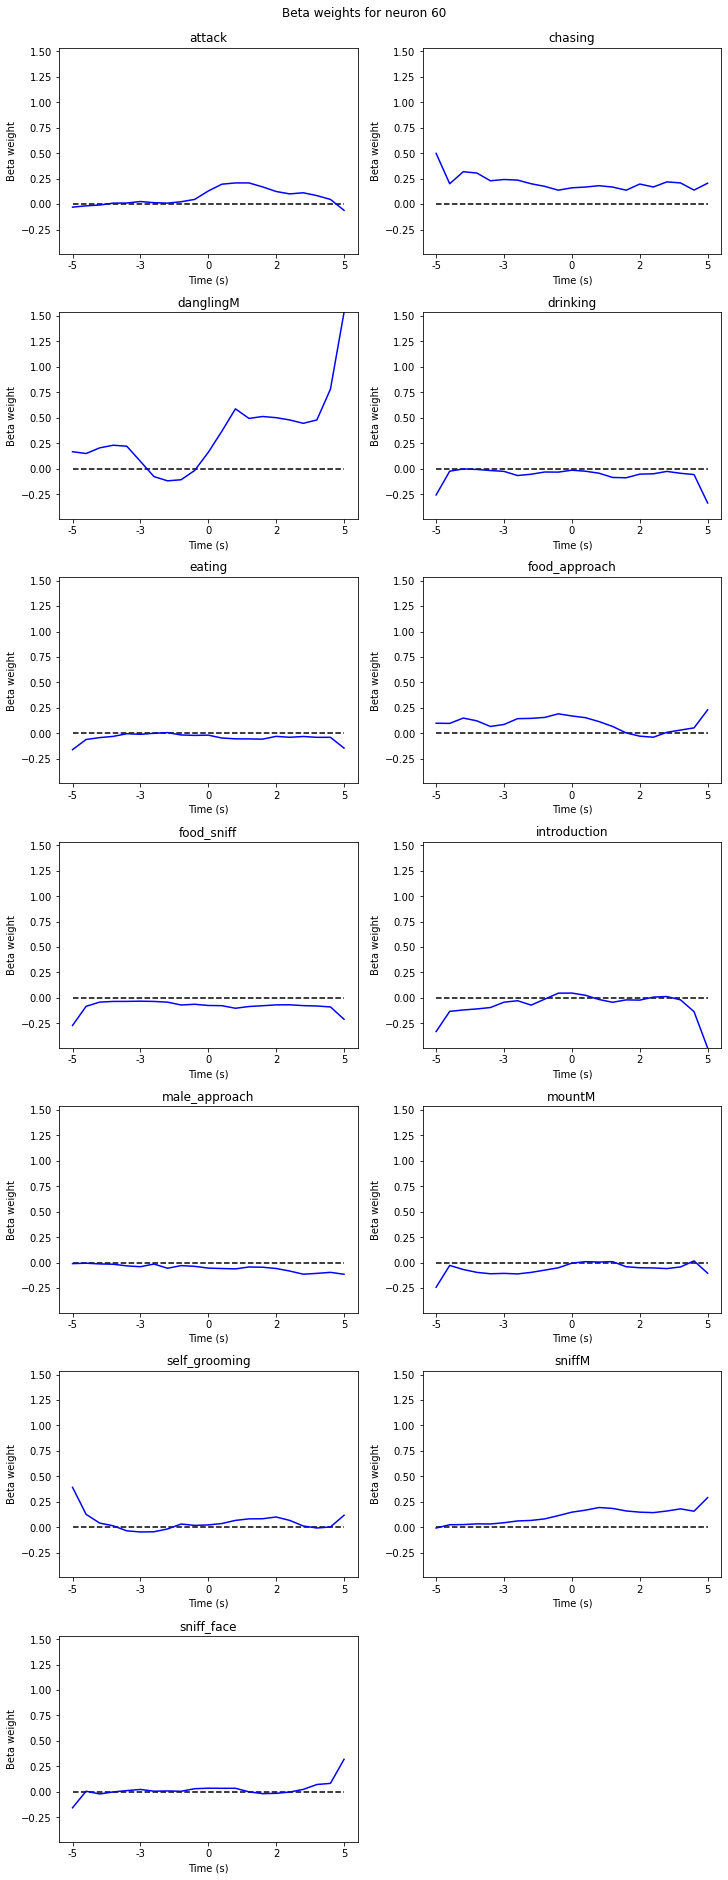

In [21]:
# Plot betas for each behavior using ridge regression (for best fit neuron using ridge regression)
fig, axs = plot_inputvar_betas(betas_ridge_reshaped, best_fit_neuronidx_ridge+1, labels, time_step, color='b')

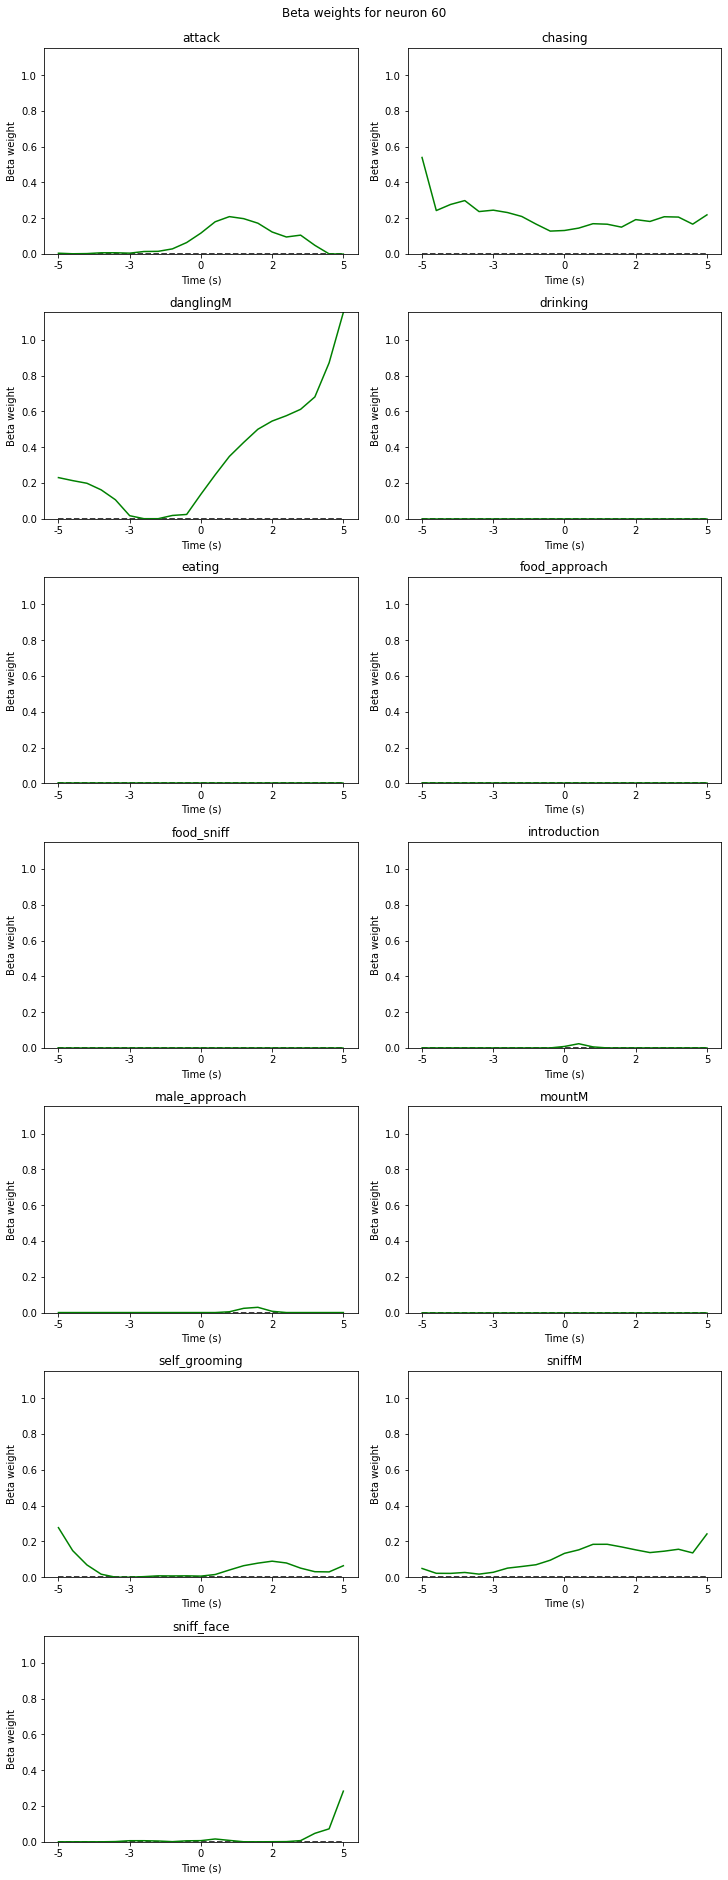

In [22]:
# Plot betas for each behavior using non-negative ridge regression (for best fit neuron using non-negative ridge regression)
fig, axs = plot_inputvar_betas(betas_nnridge_reshaped, best_fit_neuronidx_nnridge+1, labels, time_step, color='g')

### Select good fit neurons

In [23]:
# Select neurons with good fits (from OLS)
good_fit_neuron_lin = np.where(r2_lin > np.max(r2_lin)*good_beta_threshold)[0]
print(f'Number of neurons with good fits using OLS: {len(good_fit_neuron_lin)}')

# Select neurons with good fits (from ridge regression)
good_fit_neuron_ridge = np.where(r2_ridge > np.max(r2_ridge)*good_beta_threshold)[0]
print(f'Number of neurons with good fits using ridge regression: {len(good_fit_neuron_ridge)}')

# Select neurons with good fits (from non-negative ridge regression)
good_fit_neuron_nnridge = np.where(r2_nnridge > np.max(r2_nnridge)*good_beta_threshold)[0]
print(f'Number of neurons with good fits using non-negative ridge regression: {len(good_fit_neuron_nnridge)}')

# Show neurons with good fits
print(good_fit_neuron_lin+1, good_fit_neuron_ridge+1, good_fit_neuron_nnridge+1)

Number of neurons with good fits using OLS: 45
Number of neurons with good fits using ridge regression: 34
Number of neurons with good fits using non-negative ridge regression: 25
[ 1  3  5  7  8  9 10 12 14 15 16 17 19 21 22 23 25 26 27 30 32 35 36 37
 38 39 40 41 46 49 50 53 54 55 56 57 58 59 60 61 65 66 68 69 70] [ 8  9 10 12 13 14 15 16 17 19 22 23 24 25 27 30 35 36 37 38 39 40 41 54
 55 56 58 59 60 65 66 68 69 70] [14 15 22 23 25 30 35 36 37 38 39 40 41 50 54 55 56 57 58 59 60 61 65 66
 69]


### Model prediction

Plot model prediction compared actual neural data

In [24]:
# Define function to plot model prediction vs actual data
def plot_model_prediction(betas_all, x, y, neuron_idx, r2, color='r'):
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(y[:,neuron_idx], color='k', label='True') # Plot true data

    # Manually calculate ridge regression prediction
    betas = betas_all[neuron_idx, :]
    y_pred = np.zeros_like(y[:,neuron_idx])
    for i in range(x.shape[1]):
        y_pred += betas[i] * x[:,i]
    ax.plot(y_pred, color=color, label=f'Predicted (R\u00b2={round(r2[neuron_idx], 2)})')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, y.shape[0]])
    ax.set_xlabel('Time')
    ax.set_ylabel('Neural activity')
    ax.set_title(f'Prediction for neuron {neuron_idx+1}')
    ax.legend()

    return fig, ax

Text(0.5, 1.0, 'Prediction for best fit neuron (60) using non-negative ridge regression')

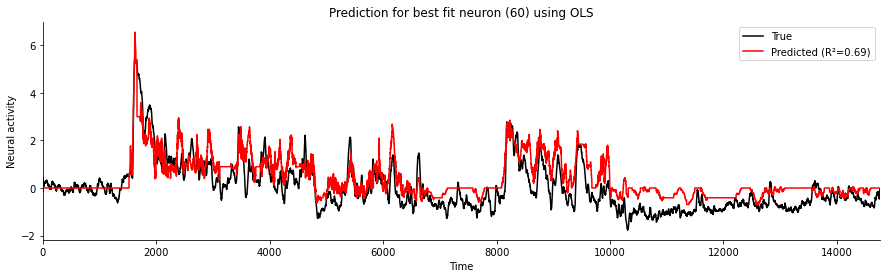

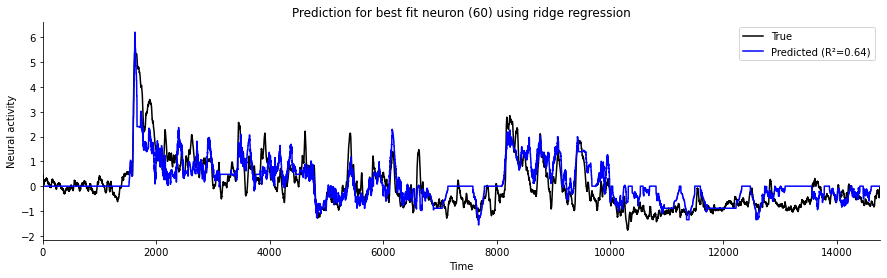

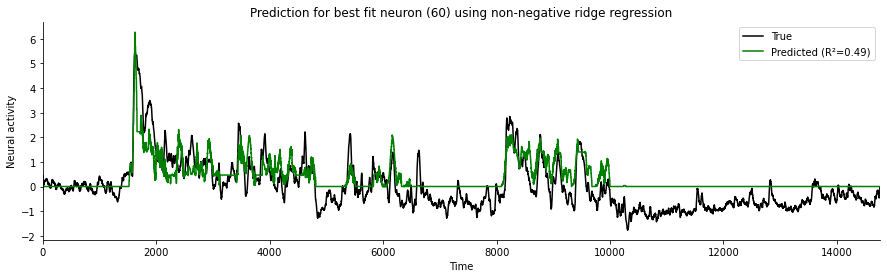

In [25]:
# Plot model prediction vs actual data for the best fit neuron from OLS
fig, ax = plot_model_prediction(betas_lin, x, y, best_fit_neuronidx_lin, r2_lin, color='r')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_lin+1}) using OLS')

# Plot model prediction vs actual data for the best fit neuron from ridge regression
fig, ax = plot_model_prediction(betas_ridge, x, y, best_fit_neuronidx_ridge, r2_ridge, color='b')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_ridge+1}) using ridge regression')

# Plot model prediction vs actual data for the best fit neuron from non-negative ridge regression
fig, ax = plot_model_prediction(betas_nnridge, x, y, best_fit_neuronidx_nnridge, r2_nnridge, color='g')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_nnridge+1}) using non-negative ridge regression')

## EDA

### Cluster beta weights

In [26]:
# Define function to perform k-means with silhouette analysis
def plot_kmeans_silhouette(range_n_clusters, data):
    """
    range_n_clusters: range of number of clusters to evaluate
    data: data to perform k-means with silhouette analysis on
    """
    num_clusters = len(range_n_clusters)
    silhouette_scores = []
    fig, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(10, 4*num_clusters), constrained_layout=True)
    for i in range(num_clusters):
        n_clusters = range_n_clusters[i]
        axs[i, 0].set_xlim([-0.1, 1])
        axs[i, 0].set_ylim([0, yd + (n_clusters + 1) * 10])

        # Fit the KMeans model and calculate silhouette scores
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        cluster_labels = kmeans.labels_
        silhouette_score_value = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_score_value)
        silhouette_scores.append(silhouette_score_value)
        silhouetee_samples = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for n in range(n_clusters):
            nth_cluster_silhouette_values = silhouetee_samples[cluster_labels == n] # Aggregate the silhouette scores for samples belonging to cluster n
            nth_cluster_silhouette_values.sort() # Sort the silhouette scores

            nth_cluster_size = nth_cluster_silhouette_values.shape[0] # Get the size of cluster n
            y_upper = y_lower + nth_cluster_size # Set the position of the silhouette plot for cluster n
            color = cm.nipy_spectral(float(n) / n_clusters)
            axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, nth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[i, 0].text(-0.05, y_lower + 0.5 * nth_cluster_size, str(n)) # Label the silhouette plots with their cluster numbers at the middle

            y_lower = y_upper + 10

        axs[i, 0].set_title("The silhouette plot for the various clusters.")
        axs[i, 0].set_xlabel("The silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_score_value, color="red", linestyle="--")
        axs[i, 0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the cluster
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        if data.shape[1] == 2:
            axs[i, 1].scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = kmeans.cluster_centers_
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("1st feature in feature space")
            axs[i, 1].set_ylabel("2nd feature in feature space")

        else:
            pca = PCA(n_components=2).fit(data)
            data_pca = pca.transform(data)
            axs[i, 1].scatter(data_pca[:, 0], data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = pca.transform(kmeans.cluster_centers_)
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("PC1 in PCA mapping of feature space")
            axs[i, 1].set_ylabel("PC2 in PCA mapping of feature space")

        plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
        )

    print("The number of clusters that maximizes silhouette score is: ", range_n_clusters[np.argmax(silhouette_scores)])
    return fig, axs, range_n_clusters[np.argmax(silhouette_scores)]

In [27]:
# Generate range of number of clusters to evaluate
range_n_clusters = np.arange(2, 10)

#### Dimensionality reduction of ridge betas using PCA

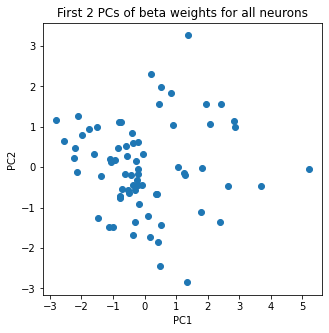

In [28]:
# Perform PCA on the beta weights
pca = PCA(n_components=2)
pca.fit(betas_ridge)
betas_ridge_pca = pca.transform(betas_ridge)

# Plot the beta weights in the PCA space
fig, ax = plt.subplots(figsize=(5, 5))
scatter = ax.scatter(betas_ridge_pca[:, 0], betas_ridge_pca[:, 1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('First 2 PCs of beta weights for all neurons')
plt.show()

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 2 the average silhouette_score is : 0.4645960674509762
For n_clusters = 3 the average silhouette_score is : 0.3640204341919036
For n_clusters = 4 the average silhouette_score is : 0.3877313192412814
For n_clusters = 5 the average silhouette_score is : 0.3724629724054967
For n_clusters = 6 the average silhouette_score is : 0.39570224973146795
For n_clusters = 7 the average silhouette_score is : 0.4228581571817713


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 the average silhouette_score is : 0.4108040084766306
For n_clusters = 9 the average silhouette_score is : 0.41911775876237856
The number of clusters that maximizes silhouette score is:  2


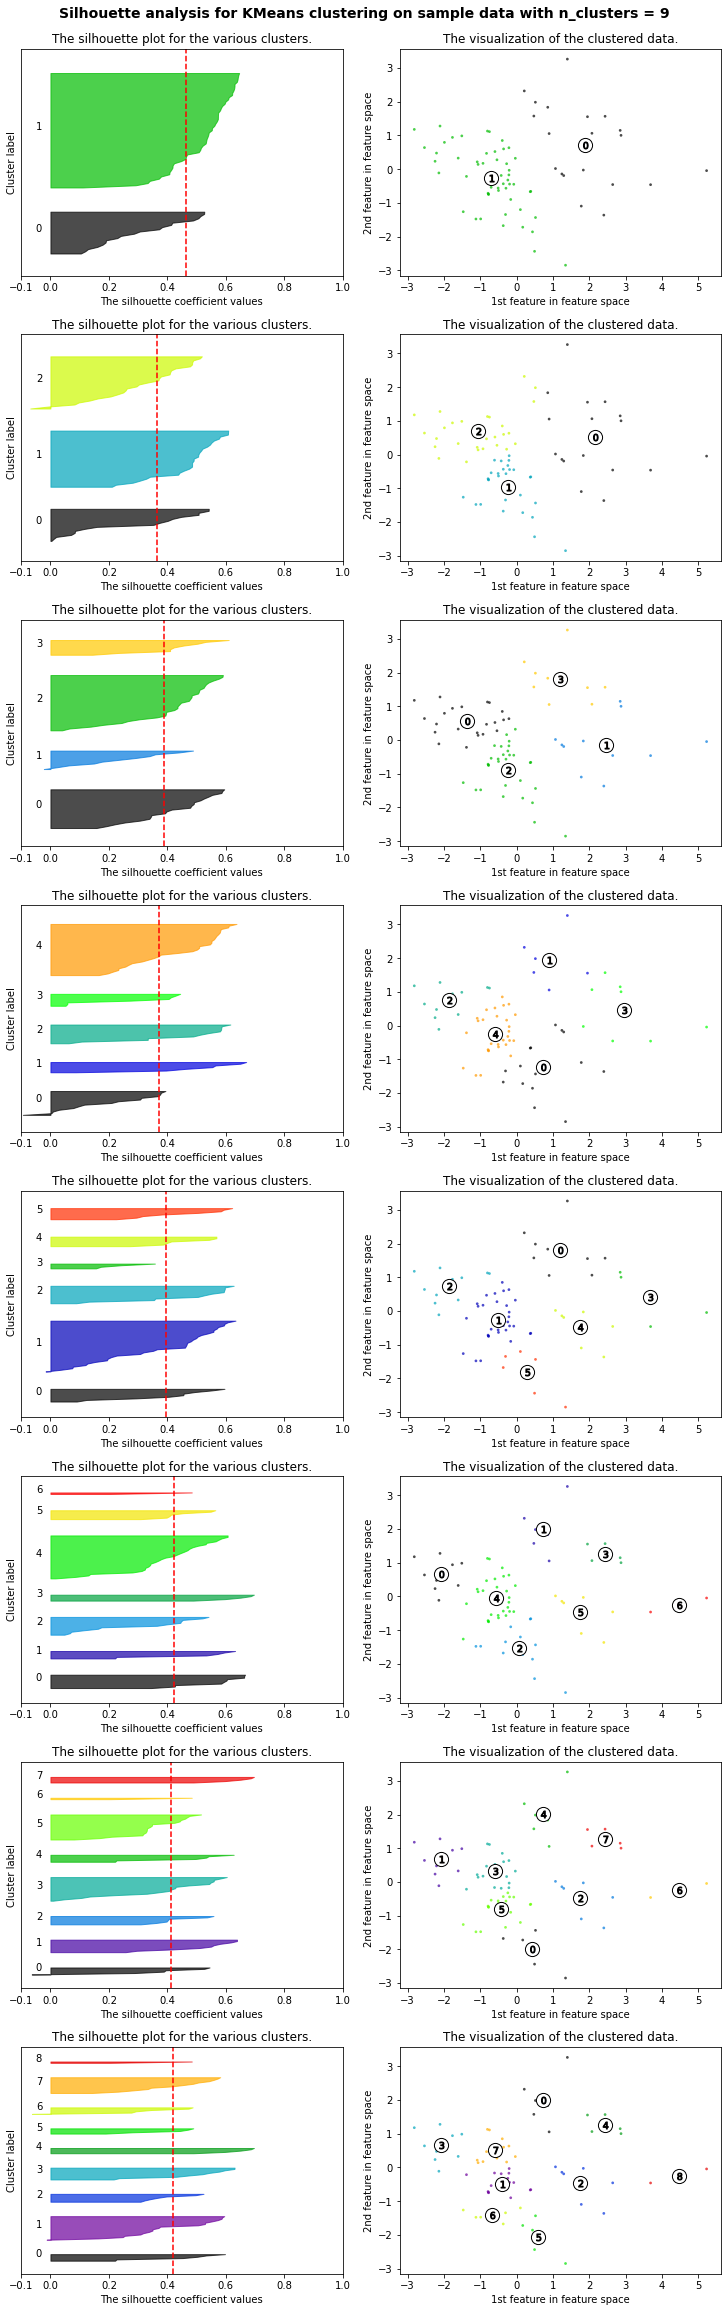

In [29]:
# Cluster beta weights in PCA space
fig, axs, best_n_clusters_pca = plot_kmeans_silhouette(range_n_clusters, betas_ridge_pca)

#### Average ridge betas across regressors for input variable

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 2 the average silhouette_score is : 0.23112040266064734
For n_clusters = 3 the average silhouette_score is : 0.17304224014347833
For n_clusters = 4 the average silhouette_score is : 0.18810936020245536
For n_clusters = 5 the average silhouette_score is : 0.16563855964931828
For n_clusters = 6 the average silhouette_score is : 0.1587654806096758
For n_clusters = 7 the average silhouette_score is : 0.19646610091848127
For n_clusters = 8 the average silhouette_score is : 0.18214766822410927


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 the average silhouette_score is : 0.17696488997614995
The number of clusters that maximizes silhouette score is:  2


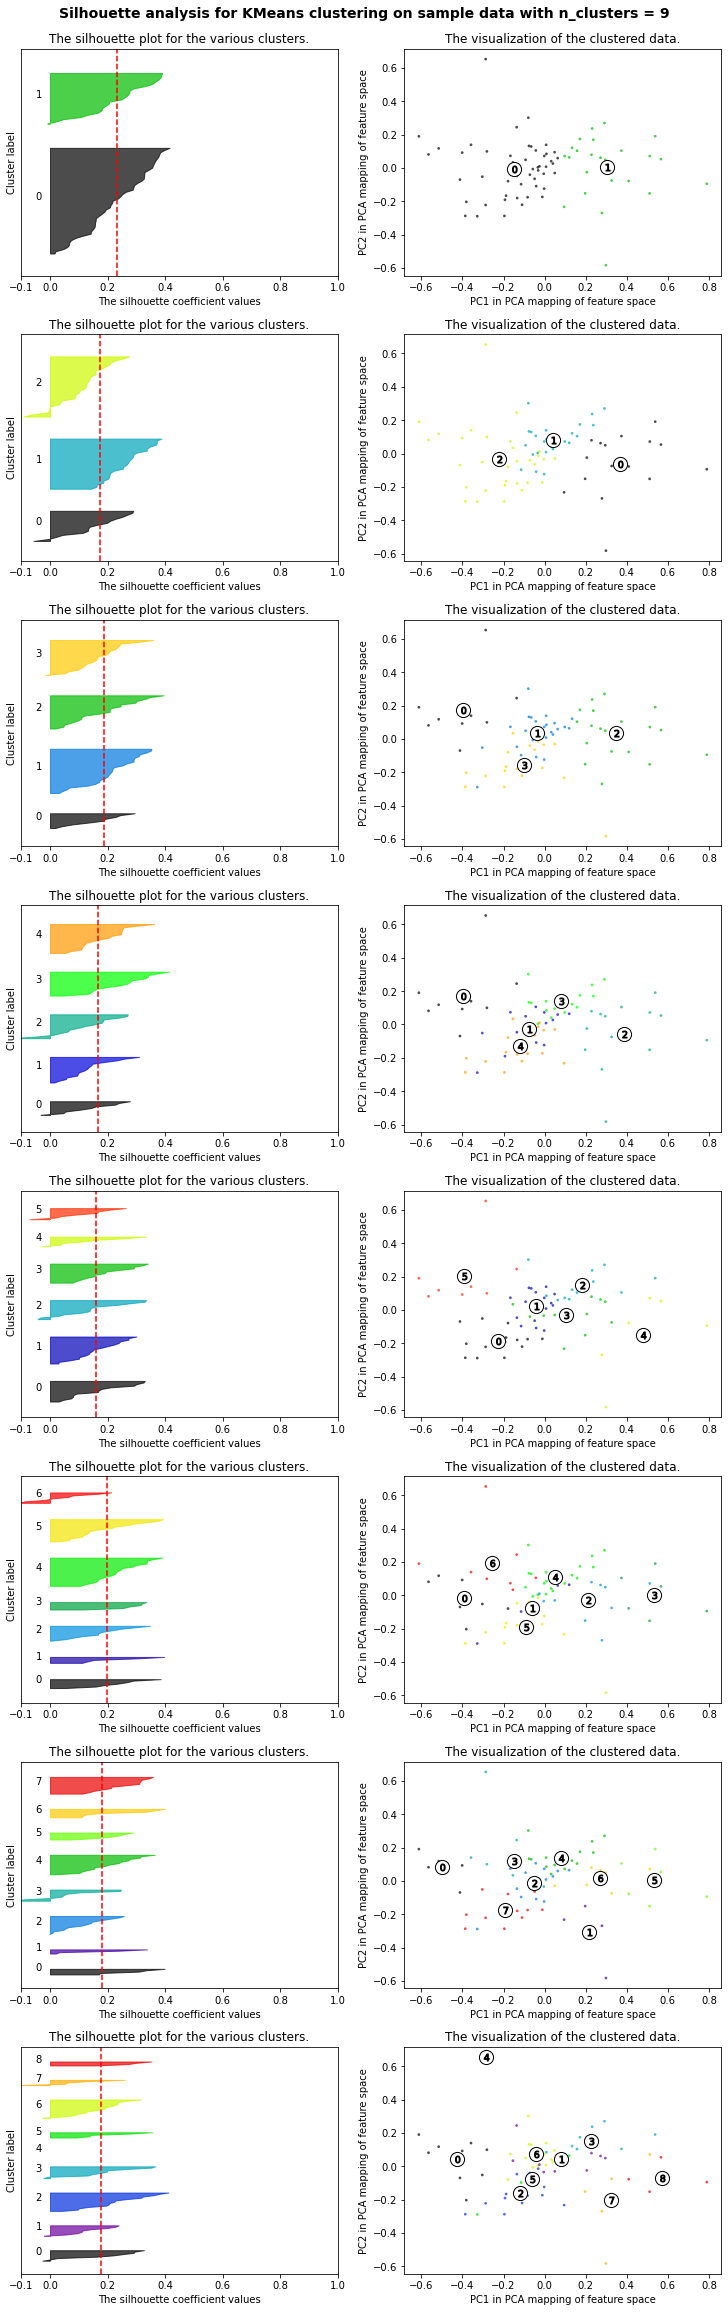

In [30]:
# Average betas across regressors for each behavior
betas_ridge_input_averaged = np.mean(betas_ridge_reshaped, axis=2)

# Cluster beta weights after averaging across regressors
fig, axs, best_n_clusters_ridge = plot_kmeans_silhouette(range_n_clusters, betas_ridge_input_averaged)

#### Average non-negative ridge betas

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 2 the average silhouette_score is : 0.3497546850548229
For n_clusters = 3 the average silhouette_score is : 0.31065727796861514
For n_clusters = 4 the average silhouette_score is : 0.30493688017998155
For n_clusters = 5 the average silhouette_score is : 0.2800157834779938
For n_clusters = 6 the average silhouette_score is : 0.2176777623655291
For n_clusters = 7 the average silhouette_score is : 0.2300418445582221
For n_clusters = 8 the average silhouette_score is : 0.20365854848176576


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 the average silhouette_score is : 0.2373423480636766
The number of clusters that maximizes silhouette score is:  2


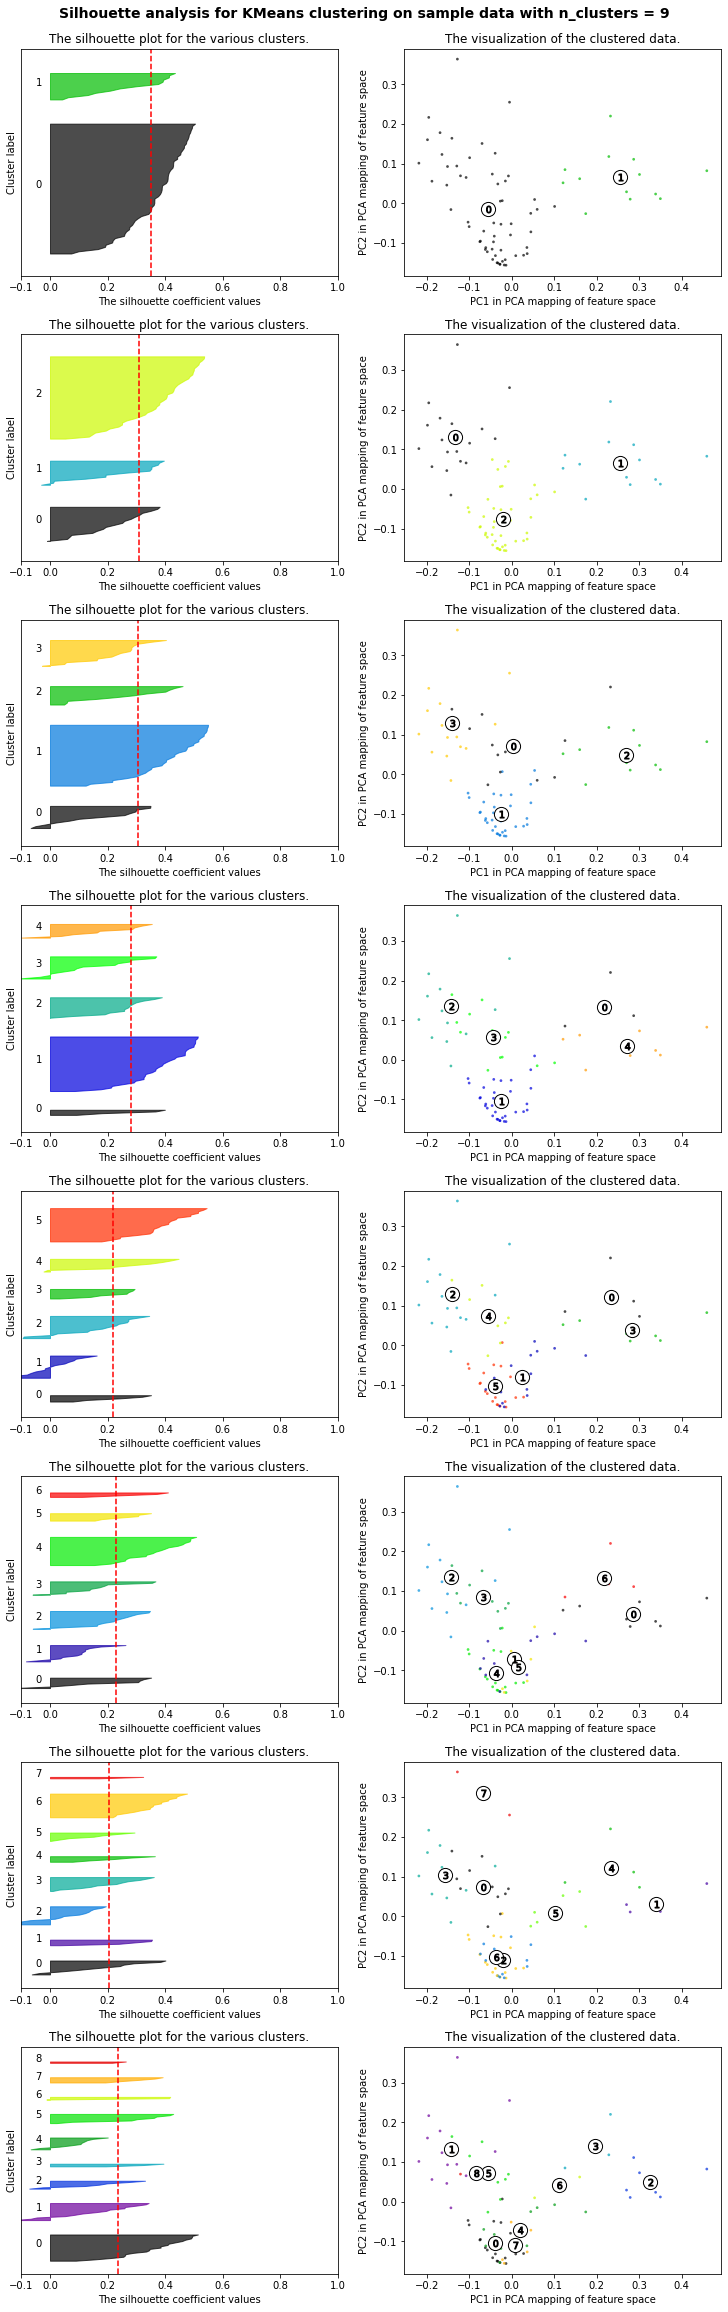

In [31]:
# Average betas across regressors for each behavior
betas_nnridge_input_averaged = np.mean(betas_nnridge_reshaped, axis=2)

# Cluster beta weights after averaging across regressors
fig, axs, best_n_clusters_nnridge = plot_kmeans_silhouette(range_n_clusters, betas_nnridge_input_averaged)

### Determine tuning profile of neuron clusters based on beta weights

In [32]:
# Define function to plot tuning of beta weights
def plot_tuning_beta(n_clusters, data, neuron_ids=None):
    # Fit k-means clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    cluster_labels = kmeans.labels_

    # Group neurons by cluster
    data_reordered = np.zeros_like(data)
    sample_ids = np.zeros_like(cluster_labels)
    n_ith_cluster_lower = 0
    n_ith_cluster_upper = 0
    for i in range(n_clusters):
        n_ith_cluster_upper = n_ith_cluster_lower + sum(cluster_labels == i)
        data_reordered[n_ith_cluster_lower:n_ith_cluster_upper, :] = data[cluster_labels == i, :]
        if neuron_ids is None:
            sample_ids[n_ith_cluster_lower:n_ith_cluster_upper] = np.where(cluster_labels == i)[0] + 1
        else:
            sample_ids[n_ith_cluster_lower:n_ith_cluster_upper] = neuron_ids[np.where(cluster_labels == i)] + 1
        n_ith_cluster_lower = n_ith_cluster_upper
    
    # Plot a heat map of beta values
    fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
    im = ax.imshow(data_reordered.T, cmap='seismic', aspect='auto')
    ax.set_xlim([-1/2, data.shape[0] - 1/2])
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_xticklabels(sample_ids, rotation=90)
    ax.set_yticks(np.arange(data.shape[1]))
    ax.set_yticklabels(labels)
    cbar = ax.figure.colorbar(im, ax=ax) # Colorbar
    cbar.ax.set_ylabel('Beta weights', rotation=-90, va="bottom")

    # Separate clusters
    for i in range(1, n_clusters):
        ax.axvline(x=np.sum(cluster_labels < i) - 1/2, color='black', linestyle='--')

    ax.set_xlabel('Neurons')
    ax.set_ylabel('Input labels')
    ax.set_title('Tuning of beta weights')
    
    return fig, ax

#### Tuning profile for all neurons

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Tuning of beta weights for all neurons using non-negative ridge regression (n_clusters = 2)')

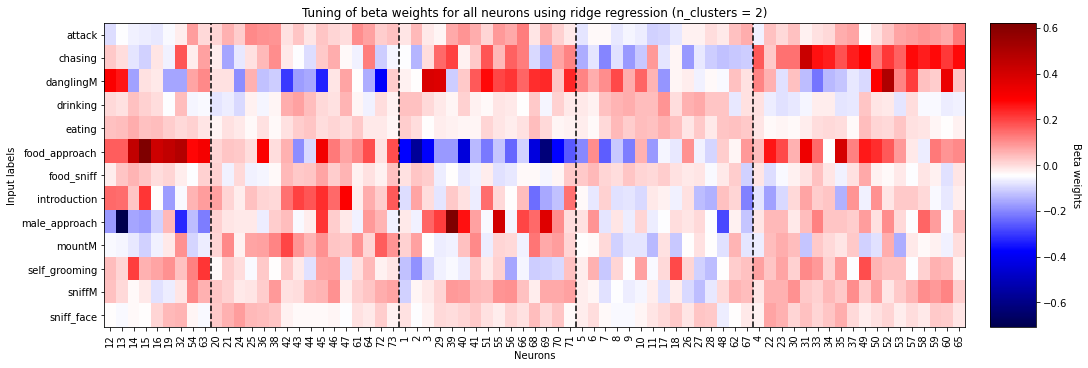

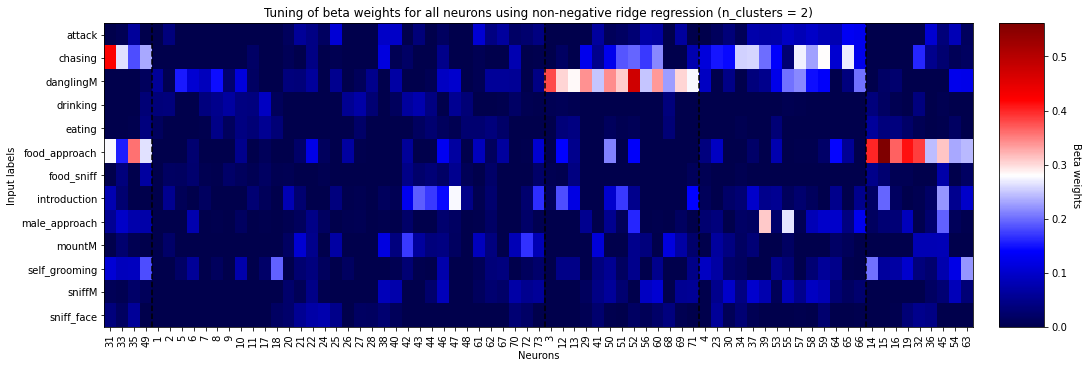

In [33]:
# Plot tuning of beta weights for all neurons
fig, ax = plot_tuning_beta(5, betas_ridge_input_averaged) # Ridge regression
ax.set_title(f'Tuning of beta weights for all neurons using ridge regression (n_clusters = {best_n_clusters_ridge})')

fig, ax = plot_tuning_beta(5, betas_nnridge_input_averaged) # Non-negative ridge regression
ax.set_title(f'Tuning of beta weights for all neurons using non-negative ridge regression (n_clusters = {best_n_clusters_nnridge})')

#### Tuning profile for good fit neurons

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 2 the average silhouette_score is : 0.2590319827443305
For n_clusters = 3 the average silhouette_score is : 0.21925967341772737
For n_clusters = 4 the average silhouette_score is : 0.20364198784417706
For n_clusters = 5 the average silhouette_score is : 0.22773347030917615
For n_clusters = 6 the average silhouette_score is : 0.23800240743947143
For n_clusters = 7 the average silhouette_score is : 0.23632794082714875
For n_clusters = 8 the average silhouette_score is : 0.20277012193035368
For n_clusters = 9 the average silhouette_score is : 0.19269659427596653
The number of clusters that maximizes silhouette score is:  2
For n_clusters = 2 the average silhouette_score is : 0.36114399358609667


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 3 the average silhouette_score is : 0.23004145173273635
For n_clusters = 4 the average silhouette_score is : 0.24146391122941074
For n_clusters = 5 the average silhouette_score is : 0.20493721568614615
For n_clusters = 6 the average silhouette_score is : 0.222259236724022
For n_clusters = 7 the average silhouette_score is : 0.2242650054291046
For n_clusters = 8 the average silhouette_score is : 0.21530922668929
For n_clusters = 9 the average silhouette_score is : 0.2068591851212333
The number of clusters that maximizes silhouette score is:  2


Text(0.5, 1.0, 'Tuning of beta weights for good fit neurons using non-negative ridge regression (n_neuron = 25, n_clusters = 2)')

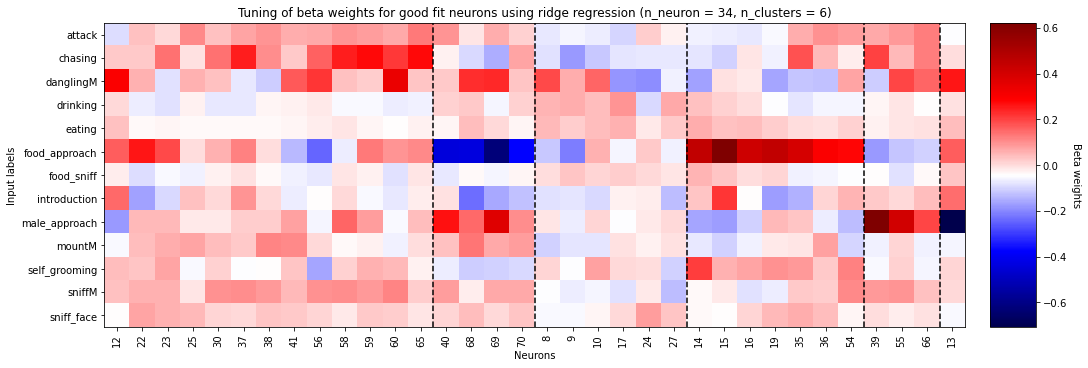

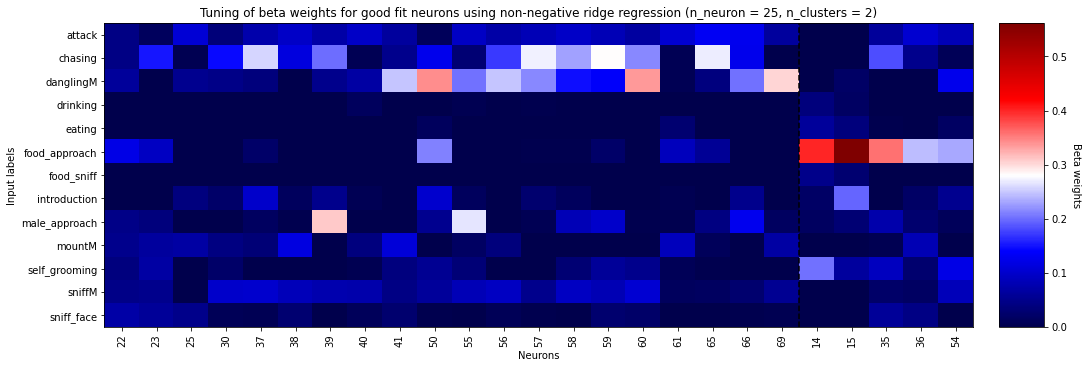

In [34]:
# Plot tuning of beta weights for good fit neurons
fig, axs, best_n_clusters_ridge_goodfit = plot_kmeans_silhouette(range_n_clusters, betas_ridge_input_averaged[good_fit_neuron_ridge, :]) # Determine best number of clusters
plt.gcf()
plt.close()
fig, ax = plot_tuning_beta(6, betas_ridge_input_averaged[good_fit_neuron_ridge, :], neuron_ids=good_fit_neuron_ridge) # Ridge regression
ax.set_title(f'Tuning of beta weights for good fit neurons using ridge regression (n_neuron = {len(good_fit_neuron_ridge)}, n_clusters = {6})')

fig, axs, best_n_clusters_nnridge_goodfit = plot_kmeans_silhouette(range_n_clusters, betas_nnridge_input_averaged[good_fit_neuron_nnridge, :]) # Determine best number of clusters
plt.gcf()
plt.close()
fig, ax = plot_tuning_beta(best_n_clusters_nnridge_goodfit, betas_nnridge_input_averaged[good_fit_neuron_nnridge, :], neuron_ids=good_fit_neuron_nnridge) # Non-negative ridge regression
ax.set_title(f'Tuning of beta weights for good fit neurons using non-negative ridge regression (n_neuron = {len(good_fit_neuron_nnridge)}, n_clusters = {best_n_clusters_nnridge_goodfit})')

### Visualize neural traces with annotations

In [35]:
# Define function to plot neural activity traces with input labels
def plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot, *optional_colors):
    """
    y: normalized neural data
    input_labeled: labeled input data
    neuron_id: neuron number
    labels_to_plot: list of labels to plot
    *optional_colors: 2-dimensional array, optional list of colors for each label
    """
    neuron_idx = neuron_id - 1
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(y[:,neuron_idx], color='k', label='neuron 19')
    ax.set_xticks(np.arange(0, y.shape[0], 2000))
    ax.set_xticklabels(np.arange(0, y.shape[0], 2000) // frame_rate)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, y.shape[0]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neural activity')
    ax.set_title(f'Neural activity (z-score) for neuron {neuron_id}')

    # Plot input labels as colored boxes
    colors = cm.rainbow_r((np.arange(len(labels_to_plot))+1)/(len(labels_to_plot)+1))
    if optional_colors:
        colors = np.concatenate((optional_colors[0], colors))
    handles, labels = ax.get_legend_handles_labels()
    handles_display = [handles[-1]]
    for l in range(len(labels_to_plot)):
        label = labels_to_plot[l]
        first = True
        for i in range(tt):
            if input_labeled[label][i] == 1 and first:
                ax.fill_between([i, i+1], y[:,neuron_idx].min(), y[:,neuron_idx].max(), color=colors[l], alpha=0.3, label=label)
                handles, labels = ax.get_legend_handles_labels()
                handles_display.append(handles[-1])
                first = False
            if input_labeled[label][i] == 1:
                ax.fill_between([i, i+1], y[:,neuron_idx].min(), y[:,neuron_idx].max(), color=colors[l], alpha=0.3, label='_nolegend_')

    ax.legend(handles_display, [f'neuron {neuron_id}'] + labels_to_plot)

    return fig, ax

In [36]:
# Custom colors for input labels
# custom_colors = np.array([[0.61, 0.18, 0.21, 1.], # attack
#                           [0.61, 0.18, 0.21, 1.], # chase
#                           [0.58, 0.78, 0.93, 1.], # sniffM
#                           [0.93, 0.4, 0.11, 1.], # eating
#                           [0.53, 0.53, 0.53, 1.]]) # food_sniff

# Custom colors for input labels
custom_colors = np.array([[0.61, 0.18, 0.21, 1.], # attack
                        #   [0.61, 0.18, 0.21, 1.], # chase
                          [0.58, 0.78, 0.93, 1.], # sniffM
                        #   [0.93, 0.4, 0.11, 1.], # eating
                          [0.53, 0.53, 0.53, 1.]]) # food_sniff

In [37]:
# EDA on chosen neuron and input labels (OLS)
# neuron_id = 13 # Neuron ID to plot
# labels_to_plot = ['attack', 'sniffM', 'eating', 'food_sniff'] # Labels to plot
# fig, ax = plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot) # Plot neural activity traces with input labels
# fig, ax = plot_model_prediction(betas_lin, x, y, neuron_id-1) # Plot model prediction vs actual data for the best fit neuron from OLS
# ax.set_title(f'Prediction for neuron {neuron_id} using OLS')
# fig, axs = plot_inputvar_betas(betas_lin_reshaped, neuron_id, labels, time_step, color='r') # Plot betas for each behavior using OLS
# fig.suptitle(f'Beta weights for neuron {neuron_id} using OLS')

In [38]:
labels

['attack',
 'chasing',
 'danglingM',
 'drinking',
 'eating',
 'food_approach',
 'food_sniff',
 'introduction',
 'male_approach',
 'mountM',
 'self_grooming',
 'sniffM',
 'sniff_face']

Text(0.5, 0.98, 'Beta weights for neuron 14 using ridge regression')

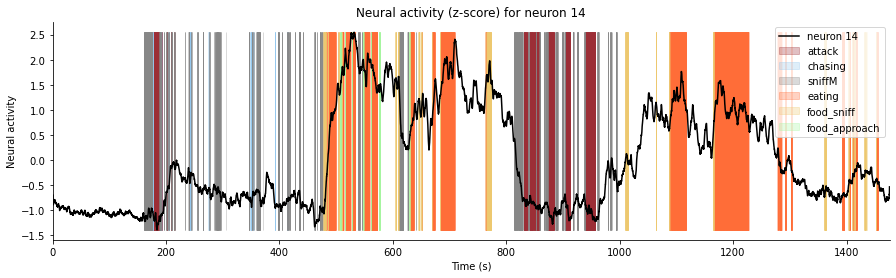

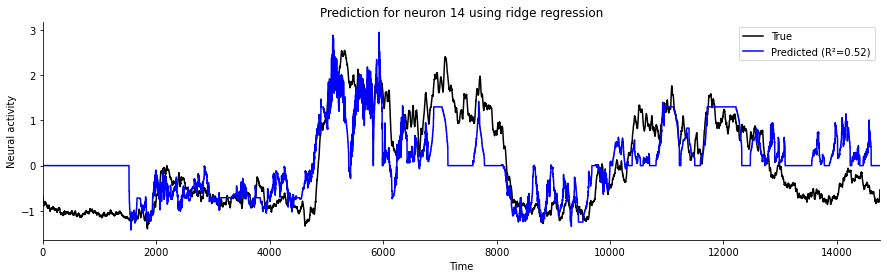

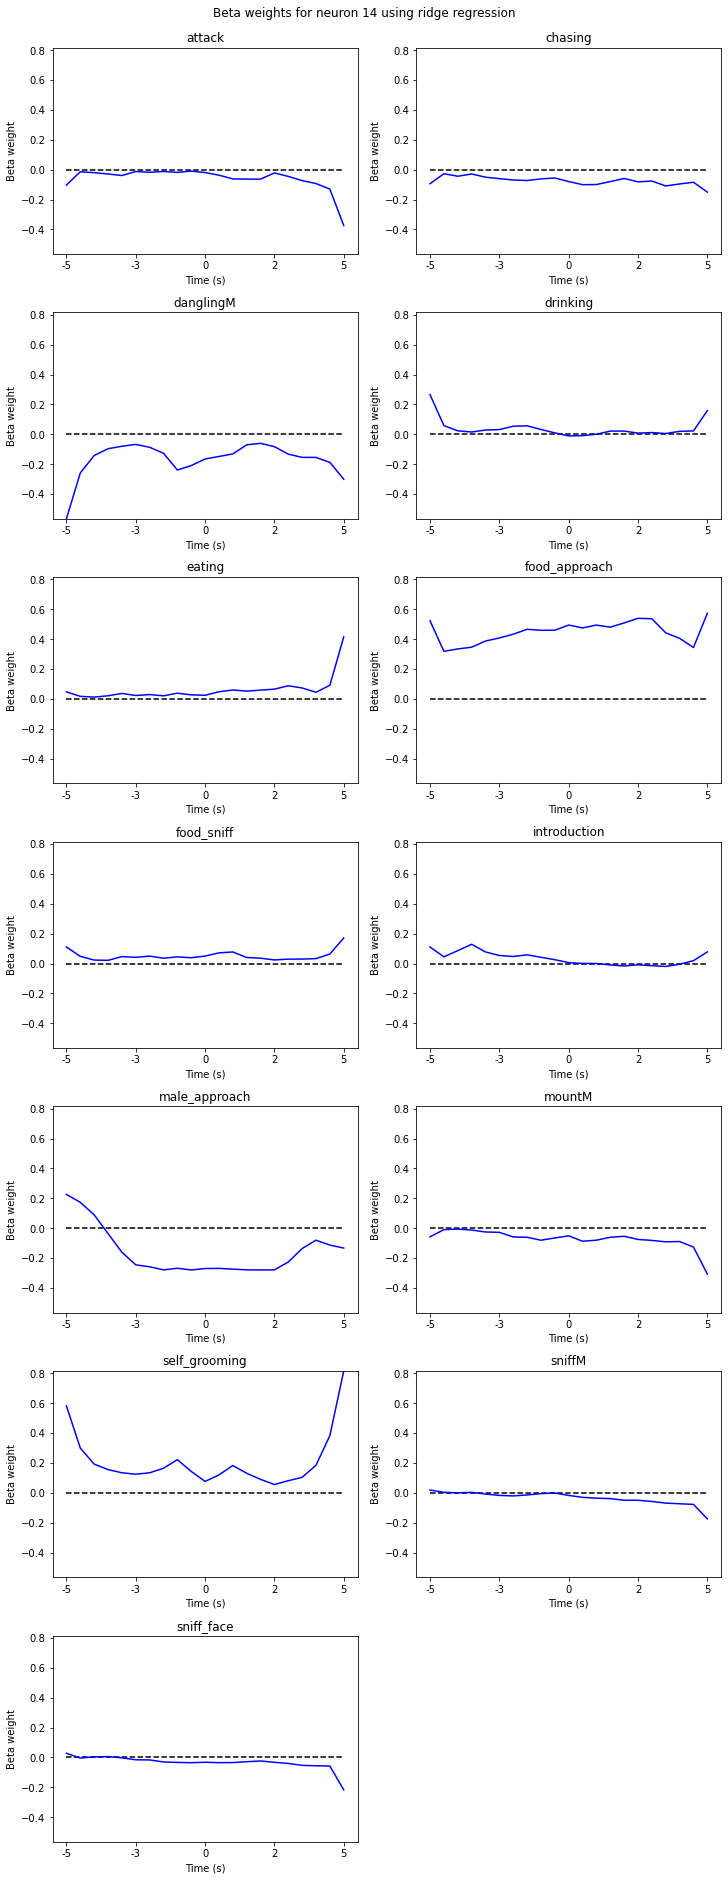

In [46]:
# EDA on chosen neuron and input labels (ridge regression)
neuron_id = 14 # Neuron ID to plot
labels_to_plot = ['attack', 'chasing', 'sniffM', 'eating', 'food_sniff', 'food_approach'] # Labels to plot
# labels_to_plot = ['attack', 'sniffM', 'food_sniff', 'attack_attempt', 'mountM']
fig, ax = plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot, custom_colors) # Plot neural activity traces with input labels
fig, ax = plot_model_prediction(betas_ridge, x, y, neuron_id-1, r2_ridge, color='b') # Plot model prediction vs actual data for the best fit neuron from ridge regression
ax.set_title(f'Prediction for neuron {neuron_id} using ridge regression')
fig, axs = plot_inputvar_betas(betas_ridge_reshaped, neuron_id, labels, time_step, color='b') # Plot betas for each behavior using ridge regression
fig.suptitle(f'Beta weights for neuron {neuron_id} using ridge regression')

Text(0.5, 0.98, 'Beta weights for neuron 15 using non-negative ridge regression')

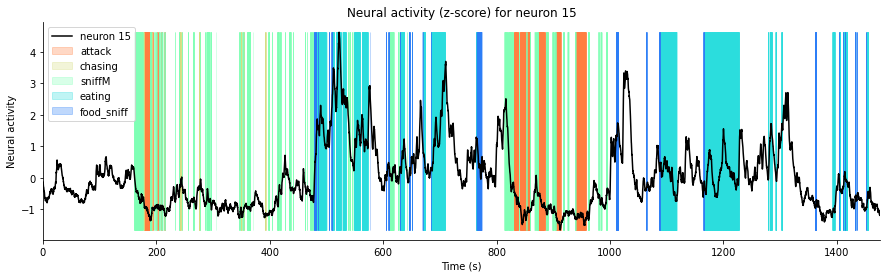

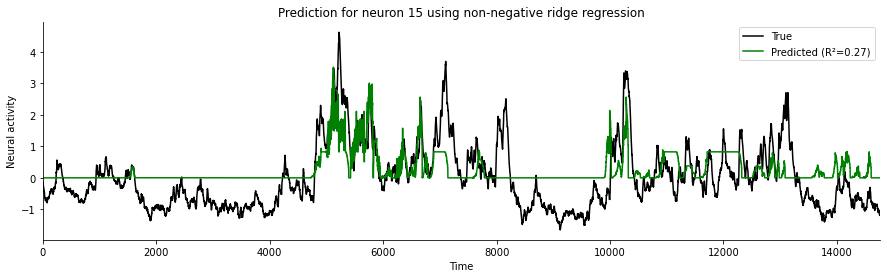

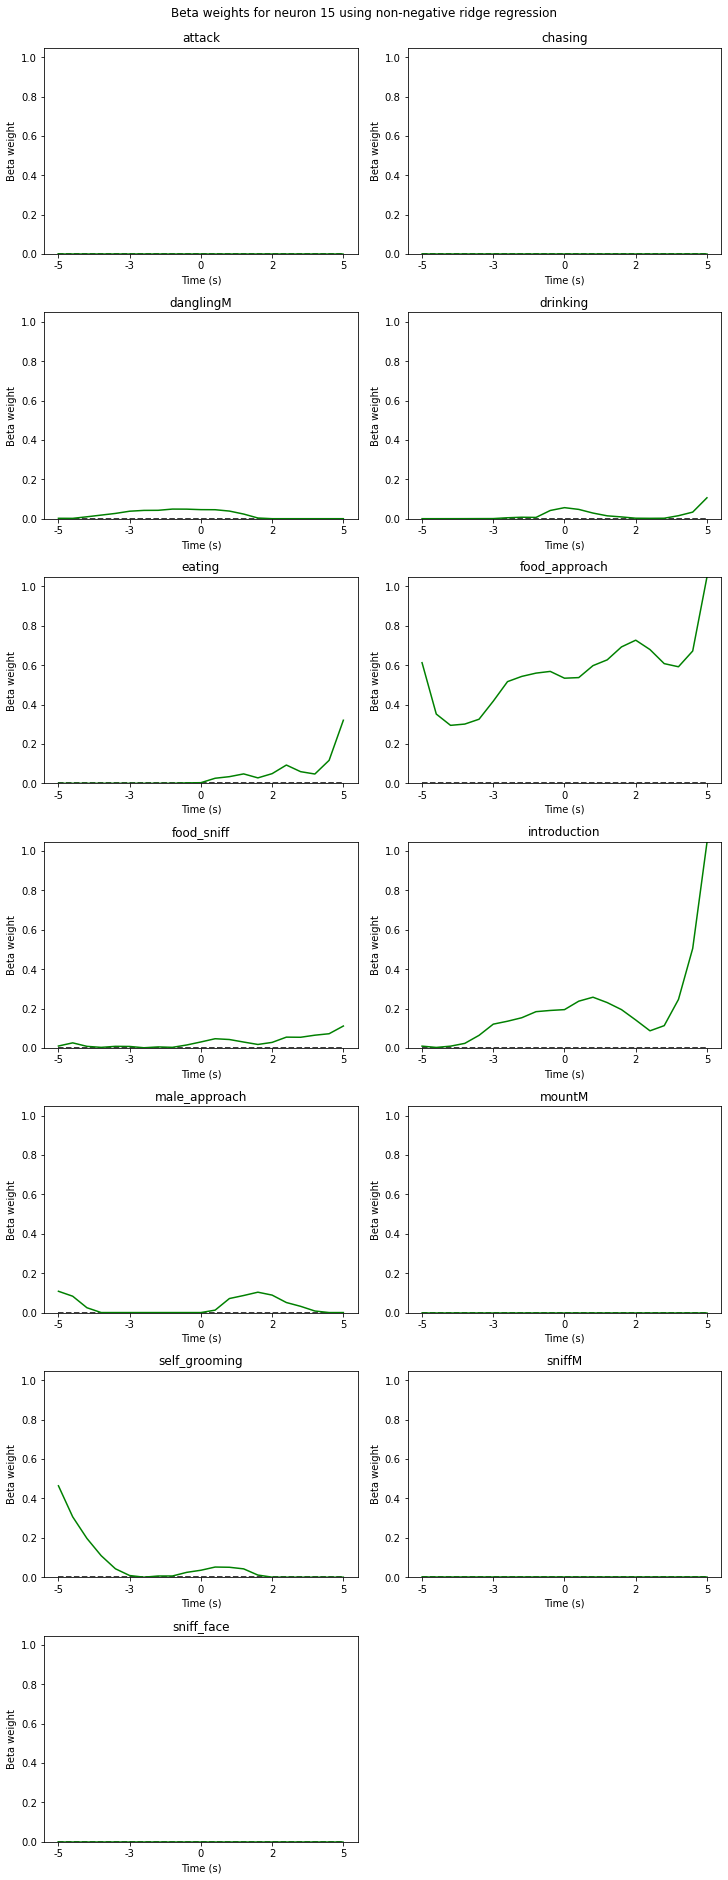

In [40]:
# EDA on chosen neuron and input labels (non-negative ridge regression)
neuron_id = 15 # Neuron ID to plot
labels_to_plot = ['attack', 'chasing', 'sniffM', 'eating', 'food_sniff'] # Labels to plot
fig, ax = plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot) # Plot neural activity traces with input labels
fig, ax = plot_model_prediction(betas_nnridge, x, y, neuron_id-1, r2_nnridge, color='g') # Plot model prediction vs actual data for the best fit neuron from non-negative ridge regression
ax.set_title(f'Prediction for neuron {neuron_id} using non-negative ridge regression')
fig, axs = plot_inputvar_betas(betas_nnridge_reshaped, neuron_id, labels, time_step, color='g') # Plot betas for each behavior using non-negative ridge regression
fig.suptitle(f'Beta weights for neuron {neuron_id} using non-negative ridge regression')

## To-do

- [ ] Add stimuli to design matrix
- [x] 5-sec window
- [x] Good fit neurons w/ thresh on R-squared
- [x] Predicted vs actual
- [ ] Cluster beta w/ k-means
  - [x] Try averaging regressor beta weights for each behavior
  - [ ] Try non-negativity constraint
    - [ ] Use LASSO
      - [ ] potentially modify from non_neg_lasso.m
    - [ ] Use ElasticNet with rho set to 0 (equiv. to ridge)
- [ ] Tuning profile of clusters


## Scratch

In [41]:
# # Function: linear regression using OLS
# def ols(x,y):
#     """
#     x: design matrix
#     y: neural data
#     """
#     betas = np.linalg.inv(x.T @ x) @ x.T @ y # the @ symbol is equivalent to np.matmul()
#     return betas

In [42]:
# # Function: R-squared
# def r_squared(y_true, y_pred):
#     """
#     y_true: true value
#     y_pred: predicted value
#     """
#     r_squared = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
#     return r_squared

In [43]:
# Separate betas according to labels
# betas_lin_labeled = {}
# betas_ridge_labeled = {}
# betas_nnridge_labeled = {}
# num_labels = len(labels)

# for i in range(num_labels):
#     betas_lin_labeled[labels[i]] = betas_lin[:, i*xd//num_labels:(i+1)*xd//num_labels]
#     betas_ridge_labeled[labels[i]] = betas_ridge[:, i*xd//num_labels:(i+1)*xd//num_labels]
#     betas_nnridge_labeled[labels[i]] = betas_nnridge[:, i*xd//num_labels:(i+1)*xd//num_labels]

# The resulting `betas_lin_labeled` dictionary will have keys corresponding to the labels in `label`, and values corresponding to the corresponding subset of columns in `xd` divided by the number of labels of columns in beta, from left to right.

In [44]:
# # Fit ridge regression with non-negative constraints using ElasticNet
# nnridgereg = linear_model.ElasticNet(alpha=alphas, l1_ratio=0, fit_intercept=fit_intercept, positive=True) # Initialize Ridge object

# betas_nnridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
# r2_nnridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

# for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
#     x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
#     y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

#     nnridgereg.fit(x_train, y_train) # Fit ElasticNet regression model
#     betas_nnridge[:,:,i] = nnridgereg.coef_ # Store betas

#     y_pred = nnridgereg.predict(x_test) # Predict y
#     r2_nnridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

# betas_nnridge = np.mean(betas_nnridge, axis=2) # Average betas across folds
# r2_nnridge = np.mean(r2_nnridge, axis=1) # Average R2 across folds

In [45]:
# Plot raw trace
# fig, ax = plt.subplots(figsize=(15, 4))
# ax.plot(y[:,18], color='k', label='neuron 19')
# ax.plot(input[0, :], color='r', label='attack')
# ax.plot(input[3, :], color='g', label='eating')
# ax.plot(input[5, :], color='b', label='foodsniff')
# ax.set_xticks(np.arange(0, y.shape[0], 2000))
# ax.set_xticklabels(np.arange(0, y.shape[0], 2000) // frame_rate)
# ax.set_xlabel('Time')
# ax.set_ylabel('Neural activity')
# ax.legend()